In [1]:
import random
import typing as tp
import time
import logging
import heapq

import torch
import torchvision as tv
from torch import Tensor, nn
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [2]:
trainset = tv.datasets.MNIST(root='./data', train=True, download=True)
train_data = trainset.data.float()
y_train = trainset.targets

testset = tv.datasets.MNIST(root='./data', train=False, download=True)
X_VAL = testset.data.float()
y_val = testset.targets
X_train = train_data.reshape((-1, 28*28))/255.
X_val = X_VAL.reshape((-1, 28*28))/255.

num_classes = torch.unique(y_train)
print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}\nX_val.shape = {X_val.shape}\ny_val.shape = {y_val.shape}")

X_train.shape = torch.Size([60000, 784])
y_train.shape = torch.Size([60000])
X_val.shape = torch.Size([10000, 784])
y_val.shape = torch.Size([10000])


In [3]:
class config:
    batch_size:int = 32
    lr:float = 1e-2
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs:int = 10
    
    classes:list[str] = trainset.classes
    num_classes:int = len(classes)
    weight_decay:float = 0.0

In [4]:
def shuffle(X:Tensor, y:Tensor): # (m, ...), (m, ...)
    """returns X, y (but shuffled)"""
    idx = torch.randperm(X.shape[0])
    return X[idx].to(config.device), y[idx].to(config.device)

def batch(X:Tensor, y:Tensor, batch_size:int):
    """returns X, y (batched form of inputs X and y)"""
    num_features = X.shape[-1]
    rem_idx = None
    if len(X)%batch_size != 0:
        rem_idx = -(len(X)%batch_size)
    X, y = shuffle(X, y) # (m, 784), (m, 10)
    X, y = X[:rem_idx], y[:rem_idx]
    X, y = X[None].reshape((-1, batch_size, num_features)), y[None].reshape((-1, batch_size))
    return X.to(device=config.device), y.to(device=config.device) # (m//B, B, 784), (m//B, B, 10)

In [5]:
def get_accuracy(y_true:Tensor, y_probs:Tensor):
    y_pred = torch.argmax(y_probs, axis=-1)
    return (y_true==y_pred).float().sum()/len(y_true)

In [6]:
class Model(nn.Module):
    def __init__(self, fan_in:int, hidden_dim:int, fan_out:int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(fan_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, fan_out)
        )
    
    def forward(self, x:Tensor) -> Tensor:
        return self.model(x)

In [7]:
class Trainer:
    def __init__(self, model:Model, use_greats:bool):
        self.model = model
        self.use_greats = use_greats

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=config.lr,
            weight_decay=config.weight_decay
        )
        self.sel_batch_func = self.GREATS if use_greats else None
    
    def _get_grad(self, x:Tensor, y:Tensor):
        nn.functional.cross_entropy(self.model(x), y).backward()
        val_grads = [p.grad for p in self.model.parameters()]
        self.model.zero_grad()
        return val_grads

    def _dot_grads(self, grads1:list[Tensor], grads2:list[Tensor]):
        return sum([(g1.flatten()).dot(g2.flatten()) for g1, g2 in zip(grads1, grads2)])
    
    # @torch.compile()
    def GREATS(
        self, X_batch: Tensor, y_batch: Tensor,
        X_val: Tensor, y_val: Tensor, 
        num_samples: int
    ):
        assert len(X_batch) > num_samples

        val_grads = self._get_grad(X_val, y_val)

        train_grads = [self._get_grad(x.unsqueeze(0), y.unsqueeze(0)) for x, y in zip(X_batch, y_batch)]
        phi_list = [config.lr * self._dot_grads(g, val_grads) for g in train_grads]

        heap = [(-phi, i) for i, phi in enumerate(phi_list)]
        heapq.heapify(heap)

        sel_indices = []
        sum_selected_grads = None

        for _ in range(num_samples):
            _, z_star_idx = heapq.heappop(heap)  # pop, highest score
            sel_indices.append(z_star_idx)

            z_star_grad = train_grads[z_star_idx]
            sum_selected_grads = z_star_grad if sum_selected_grads is None else [a + b for a, b in zip(sum_selected_grads, z_star_grad)]

            new_heap = []
            for minus_phi, i in heap:
                update_term = (config.lr**2) * self._dot_grads(train_grads[i], sum_selected_grads)
                heapq.heappush(new_heap, (minus_phi + update_term, i)) # -(phi - update_term) = -phi + update_term
            
            heap = new_heap

        return X_batch[sel_indices], y_batch[sel_indices]

    def train(self, X_train:Tensor, y_train:Tensor, X_val:Tensor, y_val:Tensor):
        autocast = torch.autocast(
            config.device.type,
            torch.bfloat16 if config.device.type == "cuda" else torch.float32
        )
        
        avg = lambda x: sum(x)/len(x)
        train_losses = []; val_losses = []
        train_accuracies = []; val_accuracies = []

        XB_train, yB_train = batch(
            X_train, y_train, config.batch_size if not self.use_greats else 2*config.batch_size
        )
        m_B = XB_train.shape[0]
        XB_val, yB_val = batch(X_val, y_val, config.batch_size)
        for epoch in range(config.num_epochs):
            print(f'|| Epoch: {epoch+1}/{config.num_epochs} ', end="")
            XB_train, yB_train = shuffle(XB_train, yB_train)
            
            for _ in range((2 if self.use_greats else 1)):
                for step in range(m_B): # (B, 784) | (B,)
                    (xtrain, ytrain) = XB_train[step], yB_train[step]
                    if self.sel_batch_func is not None:
                        xtrain, ytrain = self.sel_batch_func(
                            xtrain, ytrain, 
                            XB_val[r:=random.randint(0, len(XB_val)-1)], yB_val[r], 
                            num_samples=config.batch_size
                        )
                    with autocast:
                        y_pred = self.model(xtrain) # (B, num_classes)
                        loss:Tensor = nn.functional.cross_entropy(y_pred, ytrain)
                    train_losses.append(loss.cpu().detach().item())
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
                    train_accuracy = get_accuracy(ytrain, y_pred)
                    train_accuracies.append(train_accuracy.cpu().detach().item())
                
            
            print(f'|| training loss: {avg(train_losses[-step:]):.4f} || training accuracy: {avg(train_accuracies[-step:]):.4f}', end=" ")
            
            with torch.no_grad():
                for step, (X_val, y_val) in enumerate(zip(XB_val, yB_val)):
                    y_val_pred = self.model(X_val)
                    val_loss = nn.functional.cross_entropy(y_val_pred, y_val)
                    val_losses.append(val_loss.cpu().detach().item())
                    
                    val_accuracy = get_accuracy(y_val, y_val_pred)
                    val_accuracies.append(val_accuracy.cpu().detach().item())
            
            print(f'|| validation loss: {avg(val_losses[-step:]):.4f} || validation accuracy: {avg(val_accuracies[-step:]):.4f} ||')
        
        return train_losses, val_losses, train_accuracies, val_accuracies

In [8]:
model = Model(fan_in=784, hidden_dim=128, fan_out=config.num_classes).to(config.device)
model.compile()

trainer_greats = Trainer(model=model, use_greats=True)

train_losses_greats, val_losses_greats, train_accuracies_greats, val_accuracies_greats = trainer_greats.train(
    X_train, y_train, X_val, y_val
)

|| Epoch: 1/10 || training loss: 0.2471 || training accuracy: 0.9271 || validation loss: 0.1834 || validation accuracy: 0.9441 ||
|| Epoch: 2/10 || training loss: 0.1938 || training accuracy: 0.9452 || validation loss: 0.1561 || validation accuracy: 0.9618 ||
|| Epoch: 3/10 || training loss: 0.1633 || training accuracy: 0.9553 || validation loss: 0.1839 || validation accuracy: 0.9564 ||
|| Epoch: 4/10 || training loss: 0.1504 || training accuracy: 0.9586 || validation loss: 0.1488 || validation accuracy: 0.9616 ||
|| Epoch: 5/10 || training loss: 0.1491 || training accuracy: 0.9637 || validation loss: 0.1948 || validation accuracy: 0.9547 ||
|| Epoch: 6/10 || training loss: 0.1415 || training accuracy: 0.9639 || validation loss: 0.1688 || validation accuracy: 0.9683 ||
|| Epoch: 7/10 || training loss: 0.1130 || training accuracy: 0.9706 || validation loss: 0.1509 || validation accuracy: 0.9714 ||
|| Epoch: 8/10 || training loss: 0.1176 || training accuracy: 0.9712 || validation loss: 0

In [9]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer_greats.optimizer.state_dict(),
    'train_accuracies': train_accuracies_greats,
    'val_accuracies': val_accuracies_greats,
    'train_losses': train_losses_greats,
    'val_losses': val_losses_greats
}, 'GREATS_checkpoint.pth')

In [10]:
model = Model(fan_in=784, hidden_dim=128, fan_out=config.num_classes).to(config.device)
model.compile()

trainer = Trainer(model=model, use_greats=False)

train_losses, val_losses, train_accuracies, val_accuracies = trainer.train(
    X_train, y_train, X_val, y_val
)

# || Epoch: 1/10 || training loss: 0.2670 || training accuracy: 0.9233 || validation loss: 0.1929 || validation accuracy: 0.9472 ||
# || Epoch: 2/10 || training loss: 0.1861 || training accuracy: 0.9500 || validation loss: 0.1595 || validation accuracy: 0.9581 ||
# || Epoch: 3/10 || training loss: 0.1648 || training accuracy: 0.9567 || validation loss: 0.1759 || validation accuracy: 0.9589 ||
# || Epoch: 4/10 || training loss: 0.1418 || training accuracy: 0.9635 || validation loss: 0.1450 || validation accuracy: 0.9635 ||
# || Epoch: 5/10 || training loss: 0.1287 || training accuracy: 0.9669 || validation loss: 0.1865 || validation accuracy: 0.9606 ||
# || Epoch: 6/10 || training loss: 0.1241 || training accuracy: 0.9685 || validation loss: 0.2072 || validation accuracy: 0.9519 ||
# || Epoch: 7/10 || training loss: 0.1183 || training accuracy: 0.9700 || validation loss: 0.1731 || validation accuracy: 0.9630 ||
# || Epoch: 8/10 || training loss: 0.1157 || training accuracy: 0.9721 || validation loss: 0.1712 || validation accuracy: 0.9652 ||
# || Epoch: 9/10 || training loss: 0.1112 || training accuracy: 0.9731 || validation loss: 0.1694 || validation accuracy: 0.9631 ||
# || Epoch: 10/10 || training loss: 0.1034 || training accuracy: 0.9741 || validation loss: 0.1803 || validation accuracy: 0.9625 ||

|| Epoch: 1/10 || training loss: 0.2760 || training accuracy: 0.9213 || validation loss: 0.2125 || validation accuracy: 0.9442 ||
|| Epoch: 2/10 || training loss: 0.1918 || training accuracy: 0.9497 || validation loss: 0.1745 || validation accuracy: 0.9554 ||
|| Epoch: 3/10 || training loss: 0.1570 || training accuracy: 0.9594 || validation loss: 0.1606 || validation accuracy: 0.9583 ||
|| Epoch: 4/10 || training loss: 0.1409 || training accuracy: 0.9644 || validation loss: 0.1679 || validation accuracy: 0.9605 ||
|| Epoch: 5/10 || training loss: 0.1404 || training accuracy: 0.9656 || validation loss: 0.1794 || validation accuracy: 0.9601 ||
|| Epoch: 6/10 || training loss: 0.1238 || training accuracy: 0.9692 || validation loss: 0.1928 || validation accuracy: 0.9574 ||
|| Epoch: 7/10 || training loss: 0.1163 || training accuracy: 0.9717 || validation loss: 0.1725 || validation accuracy: 0.9613 ||
|| Epoch: 8/10 || training loss: 0.1018 || training accuracy: 0.9749 || validation loss: 0

In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses
}, 'NOGREATS_checkpoint.pth')

In [ ]:
def smooth(values, weight=0.9):
    smoothed = []
    last = values[0]
    for value in values:
        smoothed_val = last * weight + (1 - weight) * value
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

train_losses_smoothed = smooth(train_losses); greats_train_losses_smoothed = smooth(train_losses_greats)
val_losses_smoothed = smooth(val_losses); greats_val_losses_smoothed = smooth(val_losses_greats)

train_accuracies_smoothed = smooth(train_accuracies); greats_train_accuracies_smoothed = smooth(train_accuracies_greats)
val_accuracies_smoothed = smooth(val_accuracies); greats_val_accuracies_smoothed = smooth(val_accuracies_greats)

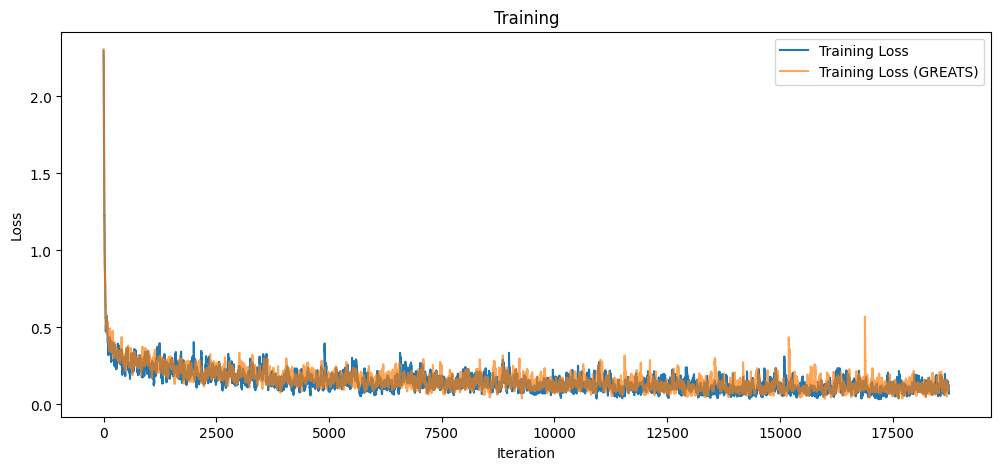

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses_smoothed, label='Training Loss')
plt.plot(greats_train_losses_smoothed, label='Training Loss (GREATS)', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

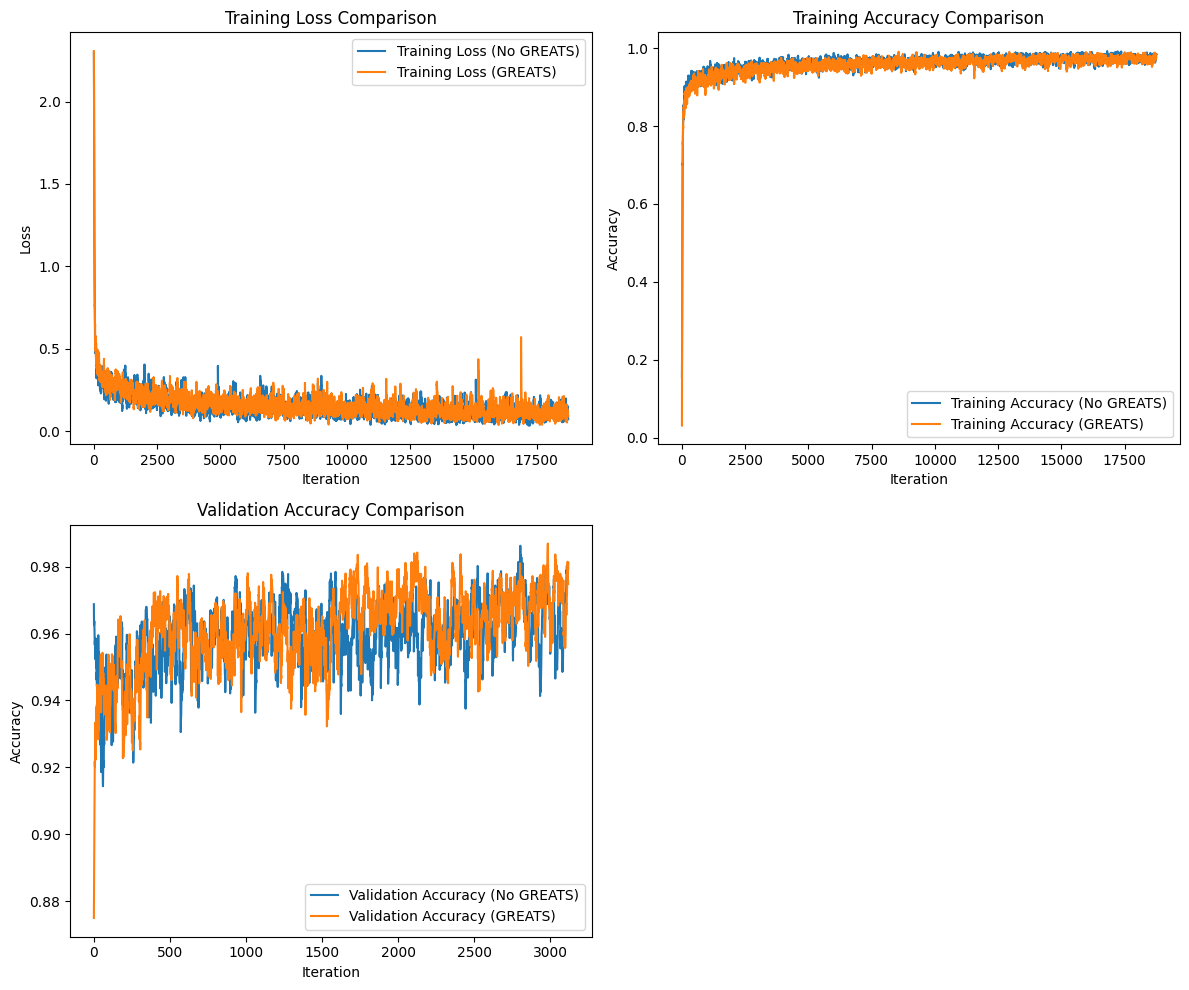

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses_smoothed, label='Training Loss (No GREATS)')
plt.plot(greats_train_losses_smoothed, label='Training Loss (GREATS)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies_smoothed, label='Training Accuracy (No GREATS)')
plt.plot(greats_train_accuracies_smoothed, label='Training Accuracy (GREATS)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(val_accuracies_smoothed, label='Validation Accuracy (No GREATS)')
plt.plot(greats_val_accuracies_smoothed, label='Validation Accuracy (GREATS)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()